# Automatic Evaluation Metrics for Enhancing the Quality of Automatic Story Generation in NLP

In [3]:
import torch
import torch.nn as nn
import traceback
from transformers import BartTokenizer, BartForConditionalGeneration
from typing import List
import numpy as np
import pandas as pd

In [46]:
df        = pd.read_csv("https://github.com/dig-team/hanna-benchmark-asg/raw/main/hanna_stories_annotations.csv")
df_scores = pd.read_csv("https://github.com/dig-team/hanna-benchmark-asg/raw/main/hanna_metric_scores.csv")


In [16]:
df.head(4)

,Story ID,Prompt,Human,Story,Model,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity,Worker ID,Assignment ID,Work time in seconds,Name
0,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,4,4,3,2,4,4,A2VE5IV9OD2SK1,3X87C8JFVHIT235KQ4UTS8264I6SQJ,579.0,None
1,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,5,5,1,3,4,1,A1IZ4NX41GKU4X,3DR23U6WEGL5K0SU6D4J8W9EM9LTE7,82.0,none
2,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,2,2,3,2,2,3,A264NN7JBX4UDQ,3UJ1CZ6IZSW49HMM6C6QUX7F7UV5SA,273.0,none
3,1,A new law is enacted that erases soldiers memo...,"“Dad, you 're on TV again !” I heard Eric 's v...","“Dad, you 're on TV again !” I heard Eric 's v...",Human,5,5,3,4,4,4,A3CFNUD7VR2E1E,317HQ483IIZJ5SPW508YKC1EP6RINX,117.0,Eric


In [140]:
df_scores#.head(4)

,Model,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity,BLEU Ξ§,ROUGE-1 Recall Ξ§,ROUGE-1 Precision Ξ§,...,Repetition-2 ¤§,Repetition-3 ¤§,SUPERT-PS ¤ε,SUPERT-SS ¤ε,BLANC-Tune-PS ¤Δ,BLANC-Help-PS ¤Δ,BLANC-Tune-SS ¤Δ,BLANC-Help-SS ¤Δ,BARTScore-PS ¤Δ,BARTScore-SP ¤Δ
0,Human,"[3.6666666666666665, 5.0, 4.666666666666667, 3...","[3.6666666666666665, 4.666666666666667, 4.6666...","[2.3333333333333335, 4.0, 4.0, 3.0, 3.0, 3.333...","[2.3333333333333335, 3.6666666666666665, 4.333...","[3.3333333333333335, 3.6666666666666665, 4.0, ...","[2.6666666666666665, 4.0, 4.333333333333333, 4...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[0.10407239819004525, 0.1198501872659176, 0.07...","[0.029288702928870293, 0.03691275167785235, 0....","[0.36060585433665243, 0.30589759827771107, 0.2...","[0.3513956792291503, 0.3298352311450941, 0.273...","[0.0, 0.040983606557377046, -0.011111111111111...","[-0.02608695652173913, 0.0, -0.011111111111111...","[0.058823529411764705, -0.14285714285714285, 0...","[-0.23529411764705882, -0.14285714285714285, 0...","[-4.046356201171875, -4.839603424072266, -4.85...","[-4.624497413635254, -6.575280666351318, -4.77..."
1,BertGeneration,"[1.6666666666666667, 3.0, 1.3333333333333333, ...","[3.6666666666666665, 2.6666666666666665, 2.333...","[2.6666666666666665, 2.6666666666666665, 1.0, ...","[1.3333333333333333, 2.0, 1.6666666666666667, ...","[2.6666666666666665, 2.6666666666666665, 1.333...","[2.6666666666666665, 2.6666666666666665, 1.333...","[1.4336111822, 1.4493826988, 0.1779090484, 0.1...","[0.38249, 0.24074, 0.16285, 0.13276, 0.40645, ...","[0.37054, 0.26639, 0.59259, 0.56771, 0.26923, ...",...,"[0.08888888888888889, 0.0546875, 0.05676855895...","[0.044534412955465584, 0.022641509433962263, 0...","[0.2597054082262463, 0.20473734339818345, 0.24...","[0.3097425349207481, 0.20473734339818345, 0.24...","[-0.01834862385321101, -0.014184397163120567, ...","[-0.03669724770642202, -0.02127659574468085, -...","[-0.058823529411764705, -0.2857142857142857, 0...","[-0.058823529411764705, -0.14285714285714285, ...","[-3.913217067718506, -5.507814407348633, -4.62...","[-4.915536880493164, -6.616286277770996, -5.14..."
2,CTRL,"[2.3333333333333335, 3.6666666666666665, 2.666...","[3.0, 3.3333333333333335, 3.3333333333333335, ...","[2.3333333333333335, 3.3333333333333335, 3.333...","[2.6666666666666665, 1.3333333333333333, 3.0, ...","[2.6666666666666665, 3.3333333333333335, 3.333...","[2.6666666666666665, 3.0, 3.0, 2.3333333333333...","[1.2558030838, 2.775216509, 0.400491848, 0.271...","[0.29954, 0.30741, 0.18702, 0.19367, 0.23871, ...","[0.38922, 0.3547, 0.54444, 0.60456, 0.30833, 0...",...,"[0.042328042328042326, 0.09154929577464789, 0....","[0.01020408163265306, 0.01910828025477707, 0.0...","[0.25552435405490376, 0.1820114012358586, 0.30...","[0.25552435405490376, 0.14368366145385317, 0.2...","[0.0, 0.008333333333333333, -0.011904761904761...","[-0.012345679012345678, -0.008333333333333333,...","[-0.058823529411764705, 0.0, 0.0, 0.0, 0.0, 0....","[-0.058823529411764705, -0.14285714285714285, ...","[-5.204783916473389, -4.947543144226074, -4.69...","[-4.883750915527344, -6.809321403503418, -4.91..."
3,GPT,"[3.6666666666666665, 3.0, 2.6666666666666665, ...","[3.6666666666666665, 3.0, 2.3333333333333335, ...","[3.0, 2.3333333333333335, 2.6666666666666665, ...","[3.0, 2.3333333333333335, 1.3333333333333333, ...","[3.0, 3.0, 2.0, 2.3333333333333335, 3.0, 3.0, ...","[2.6666666666666665, 3.0, 2.3333333333333335, ...","[0.9493520114, 2.3140339956, 0.1505541131, 0.2...","[0.24424, 0.3037, 0.1374, 0.05359, 0.34194, 0....","[0.29944, 0.36771, 0.5567, 0.72131, 0.26633, 0...",...,"[0.075, 0.07623318385650224, 0.137055837563451...","[0.018779342723004695, 0.012195121951219513, 0...","[0.3434531769248544, 0.2605565346424716, 0.309...","[0.3892346136855479, 0.2520803726283153, 0.310...","[0.010638297872340425, -0.0175

#### Different ASG models:

In [14]:
df['Model'].unique()

array(['Human', 'BertGeneration', 'CTRL', 'GPT', 'GPT-2 (tag)', 'GPT-2',
       'RoBERTa', 'XLNet', 'Fusion', 'HINT', 'TD-VAE'], dtype=object)

In [143]:
df_scores['Model'].unique()

array(['Human', 'BertGeneration', 'CTRL', 'GPT', 'GPT-2 (tag)', 'GPT-2',
       'RoBERTa', 'XLNet', 'Fusion', 'HINT', 'TD-VAE'], dtype=object)

### Define the metrics of interest:

In the evaluation metrics that produce three columns (e.g., ROUGE, METEOR), recall, precision, and F-score (score) are computed.

**The score column represents the harmonic mean of recall and precision. It is a commonly used metric because it provides a balance between recall and precision.**

If you only care about one of recall or precision, then you should look at the column that corresponds to that metric. If you want a balanced evaluation of the system's performance, you should look at the score column.

In [148]:
df_scores.columns[:]

Index(['Model', 'Relevance', 'Coherence', 'Empathy', 'Surprise', 'Engagement',
       'Complexity', 'BLEU Ξ§', 'ROUGE-1 Recall Ξ§', 'ROUGE-1 Precision Ξ§',
       'ROUGE-1 F-Score Ξ§', 'ROUGE-2 Recall Ξ§', 'ROUGE-2 Precision Ξ§',
       'ROUGE-2 F-Score Ξ§', 'ROUGE-3 Recall Ξ§', 'ROUGE-3 Precision Ξ§',
       'ROUGE-3 F-Score Ξ§', 'ROUGE-4 Recall Ξ§', 'ROUGE-4 Precision Ξ§',
       'ROUGE-4 F-Score Ξ§', 'ROUGE-L Recall Ξ§', 'ROUGE-L Precision Ξ§',
       'ROUGE-L F-Score Ξ§', 'ROUGE-W-1.2 Recall Ξ§',
       'ROUGE-W-1.2 Precision Ξ§', 'ROUGE-W-1.2 F-Score Ξ§',
       'ROUGE-S* Recall Ξ§', 'ROUGE-S* Precision Ξ§', 'ROUGE-S* F-Score Ξ§',
       'ROUGE-SU* Recall Ξ§', 'ROUGE-SU* Precision Ξ§', 'ROUGE-SU* F-Score Ξ§',
       'METEOR Ξ§', 'chrF Ξ§', 'CIDEr Ξ§', 'ROUGE-WE-3 Recall Ξε',
       'ROUGE-WE-3 Precision Ξε', 'ROUGE-WE-3 F-Score Ξε',
       'BERTScore Precision Ξε', 'BERTScore Recall Ξε', 'BERTScore F1 Ξε',
       'MoverScore Ξε', 'DepthScore Ξε', 'BaryScore-W Ξε',
       'BaryScor

In [160]:
human_metrics = ['Relevance', 'Coherence', 'Empathy', 'Surprise', 'Engagement', 'Complexity']
AEM_metrics   = ['BLEU Ξ§', 'ROUGE-1 F-Score Ξ§', 'ROUGE-2 F-Score Ξ§', 'ROUGE-3 F-Score Ξ§', 'ROUGE-4 F-Score Ξ§', 
                 'ROUGE-L F-Score Ξ§', 'ROUGE-W-1.2 F-Score Ξ§', 'METEOR Ξ§', 'BERTScore F1 Ξε']

#Automatic_metrics = list(df_scores.columns[7:14])
corr_interest = ["pearson", "kendall", "spearman"]

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a family of evaluation metrics for automatic summarization and machine translation. The different variants of ROUGE evaluate different aspects of the generated summary compared to the reference summary.

* ROUGE-1 measures the overlap in unigram (single word) between the generated and reference summaries.
* ROUGE-2 measures the overlap in bigram (pairs of adjacent words) between the generated and reference summaries.
* ROUGE-L (Longest Common Subsequence) measures the longest common subsequence between the generated and reference summaries, which is the length of the longest sequence of words that appears in the same order in both summaries.
* ROUGE-W (Weighted ROUGE) is a variant of ROUGE-L that gives more weight to longer sequences of words.

In general, ROUGE-1 and ROUGE-2 are more sensitive to surface-level similarities between the generated and reference summaries, while ROUGE-L and ROUGE-W are more sensitive to the semantic similarity between the summaries.

## <font color='orange'>1. Text-level</font>

The function *"my\_func"* was used for creating text-level correlation plots, where each story was considered as a single data point.

In [186]:
import random
import string
import json
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.pyplot as plt
import seaborn as sns

def my_func(a, b, c, d, path, e = (30, 45), f = None, g = None):
    N = len(a)
    M = len(b)
    corr_matrix = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            c_metric1 = np.array([json.loads(l) for l in c[a[i]].tolist()]).T
            c_metric2 = np.array([json.loads(l) for l in c[b[j]].tolist()]).T

            if d == 'kendall':
                k = np.zeros(96)
                for l in range(96):
                    k[l] = kendalltau(c_metric1[l], c_metric2[l])[0]
                corr_matrix[i,j] = abs(round(100*k.mean()))
            elif d == 'pearson':
                k = np.zeros(96)
                for l in range(96):
                    k[l] = pearsonr(c_metric1[l], c_metric2[l])[0]
                corr_matrix[i,j] = abs(round(100*k.mean()))
            elif d == 'spearman':
                k = np.zeros(96)
                for l in range(96):
                    k[l] = spearmanr(c_metric1[l], c_metric2[l])[0]
                corr_matrix[i,j] = abs(round(100*k.mean()))

    if g == None:
        nm2 = b
    else:
        nm2 = g
    if f == None:
        nm1 = a
    else:
        nm1 = f
    
    if a==b :
        uh = np.triu(np.ones_like(corr_matrix, dtype=bool))
    else :
        uh = False 
        
    plt.figure(figsize=e)
    heatmap = sns.heatmap(corr_matrix,
                           annot=True,
                           cmap='YlGnBu',
                           square=True,
                           vmin=0,
                           vmax=100,
                           xticklabels=nm2,
                           yticklabels=nm1,
                           cbar=False,
                           mask = uh)
    heatmap.set_xticklabels(heatmap.get_xticklabels(),
                             rotation=45,
                             ha='right')
    #plt.savefig(path, dpi=600)
    plt.show()
    #return path


Use of the previous function:
* a = the list with the names of the metric you want your lines to be
* b = the list with the names of the metric you want your columns to be
* c = the dataset to use
* d = the creterion of interest (in *corr_interest*)

## Human criteria

#### Pearson correlations (%) between human criteria

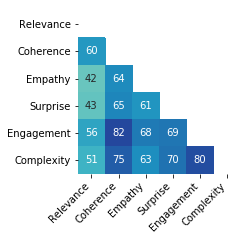

In [187]:
my_func(human_metrics, human_metrics, df_scores, 'pearson', 'firsttry', e = (3, 3))

#### Kendall correlations (%) between human criteria

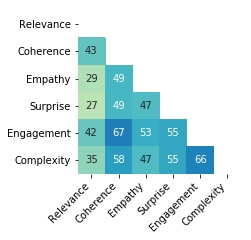

In [188]:
my_func(human_metrics, human_metrics, df_scores, 'kendall', 'firsttry', e = (3, 3))

#### Spearman correlations (%) between human criteria

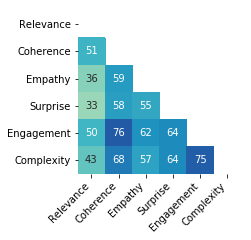

In [189]:
my_func(human_metrics, human_metrics, df_scores, 'spearman', 'firsttry', e = (3, 3))

## AEM : Automatic Evaluation Metrics

#### Pearson correlations (%) between AEM

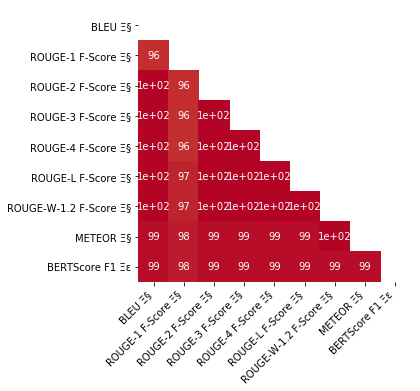

In [162]:
my_func(AEM_metrics, AEM_metrics, df_scores, 'pearson', 'firsttry', e = (5, 5))

#### Kendall correlations (%) between AEM

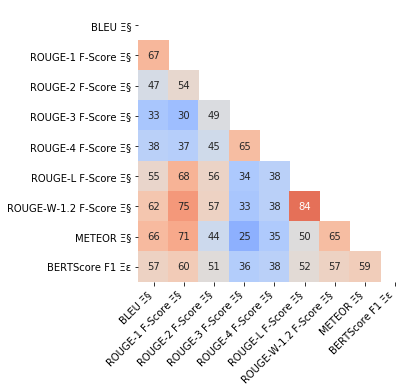

In [163]:
my_func(AEM_metrics, AEM_metrics, df_scores, 'kendall', 'firsttry', e = (5, 5))

#### Spearman correlations (%) between AEM

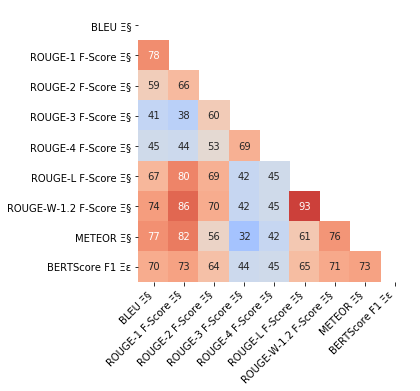

In [164]:
my_func(AEM_metrics, AEM_metrics, df_scores, 'spearman', 'firsttry', e = (5, 5))

## Correlation human criteria / AEM

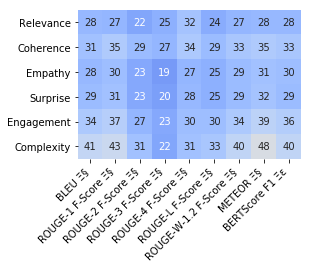

In [171]:
my_func(human_metrics, AEM_metrics, df_scores, 'kendall', 'firsttry', e = (4, 4))

## <font color='orange'>2. System-level</font>

The function *"my\_func"* was used for creating text-level correlation plots, where each story was considered as a single data point, while the *"my\_func\_sys"* function is used for creating system-level correlation plots, where the metrics are aggregated across all the stories in the system and each metric is considered as a single data point. The system-level plot can be used to analyze the overall correlation between the two sets of metrics at the system level, whereas the text-level plot focuses on the correlation between metrics for each individual story.

The modified *"my_func_sys"* is evaluating system-level metrics, as it is computing the correlation between the means of the metrics across all stories in the dataset, rather than at the individual story level. This is achieved by averaging the metrics across all stories before computing the correlation coefficient.

In [182]:
def my_func_sys(a, b, c, d, path, e=(30, 45), f=None, g=None):
    N = len(a)
    M = len(b)
    corr_matrix = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            c_metric1 = np.array([json.loads(l) for l in c[a[i]].tolist()]).T
            c_metric2 = np.array([json.loads(l) for l in c[b[j]].tolist()]).T

            if d == 'kendall':
                k = kendalltau(np.mean(c_metric1, axis=0), np.mean(c_metric2, axis=0))[0]
                corr_matrix[i, j] = abs(round(100 * k))
            elif d == 'pearson':
                k = pearsonr(np.mean(c_metric1, axis=0), np.mean(c_metric2, axis=0))[0]
                corr_matrix[i, j] = abs(round(100 * k))
            elif d == 'spearman':
                k = spearmanr(np.mean(c_metric1, axis=0), np.mean(c_metric2, axis=0))[0]
                corr_matrix[i, j] = abs(round(100 * k))

    if g is None:
        nm2 = b
    else:
        nm2 = g
    if f is None:
        nm1 = a
    else:
        nm1 = f
        
    if a==b :
        uh = np.triu(np.ones_like(corr_matrix, dtype=bool))
    else :
        uh = False 

    plt.figure(figsize=e)
    heatmap = sns.heatmap(corr_matrix,
                           annot=True,
                           cmap='YlGnBu',#'coolwarm',
                           square=True,
                           vmin=0,
                           vmax=100,
                           xticklabels=nm2,
                           yticklabels=nm1,
                           cbar=False,
                         mask = uh)
    heatmap.set_xticklabels(heatmap.get_xticklabels(),
                             rotation=45,
                             ha='right')
    #plt.savefig(path, dpi=600)
    plt.show()
    #return path


<font color='orange'> **We focus on (absolute) Kendall correlations.** </font>

#### Kendall correlations (%) between human criteria

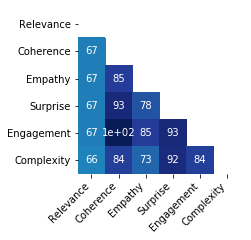

In [183]:
my_func_sys(human_metrics, human_metrics, df_scores, 'kendall', 'firsttry', e = (3, 3))

#### Kendall correlations (%) between AEM at system-level

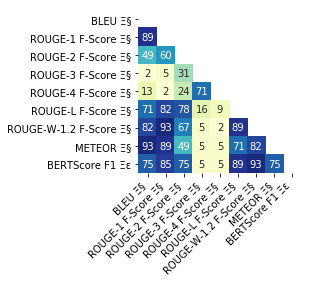

In [184]:
my_func_sys(AEM_metrics, AEM_metrics, df_scores, 'kendall', 'firsttry', e = (3, 3))

### Correlation human criteria / AEM at system level

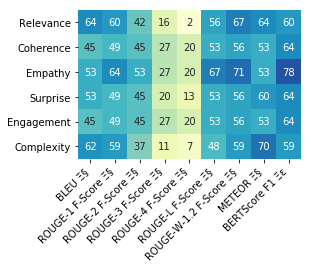

In [185]:
my_func_sys(human_metrics, AEM_metrics, df_scores, 'kendall', 'firsttry', e = (4, 4))

## <font color='orange'>"Best metrics" for the human evaluation</font>

Voici une fonction *my_func_sys_top* qui utilise la fonction *my_func_sys* pour calculer les corrélations entre les AEM et l'évaluation humaine, puis renvoie les X meilleures AEM en fonction de l'évaluation humaine :

Use of the following function:
* a = the list with the names of the metric you want your lines to be
* b = the list with the names of the metric you want your columns to be
* c = the dataset to use
* d = the creterion of interest (in *corr_interest*)
* e = nomber of best AEM 

In [265]:
def my_func_sys_top(a, b, c, d, x, e, f=None, g=None):
    N = len(a)
    M = len(b)
    corr_matrix = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            c_metric1 = np.array([json.loads(l) for l in c[a[i]].tolist()]).T
            c_metric2 = np.array([json.loads(l) for l in c[b[j]].tolist()]).T

            if d == 'kendall':
                k = kendalltau(np.mean(c_metric1, axis=0), np.mean(c_metric2, axis=0))[0]
                corr_matrix[i, j] = abs(round(100 * k))
            elif d == 'pearson':
                k = pearsonr(np.mean(c_metric1, axis=0), np.mean(c_metric2, axis=0))[0]
                corr_matrix[i, j] = abs(round(100 * k))
            elif d == 'spearman':
                k = spearmanr(np.mean(c_metric1, axis=0), np.mean(c_metric2, axis=0))[0]
                corr_matrix[i, j] = abs(round(100 * k))

    if g is None:
        nm2 = b
    else:
        nm2 = g
    if f is None:
        nm1 = a
    else:
        nm1 = f
        
    if a==b :
        uh = np.triu(np.ones_like(corr_matrix, dtype=bool))
    else :
        uh = False 
        
    nm2 = np.array(nm2)
    plt.figure(figsize=e)
    heatmap = sns.heatmap(corr_matrix,
                           annot=True,
                           cmap='YlGnBu',
                           square=True,
                           vmin=0,
                           vmax=100,
                           xticklabels=nm2,
                           yticklabels=nm1,
                           cbar=False,
                         mask = uh)
    heatmap.set_xticklabels(heatmap.get_xticklabels(),
                             rotation=45,
                             ha='right')

    sorted_idx = np.argsort(corr_matrix.sum(axis=0))[::-1]
    sorted_idx_list = sorted_idx.tolist()
    top_aem = nm2[sorted_idx_list][:x]

    plt.show()

    return list(top_aem)


#### Evaluation : Pearson correlation

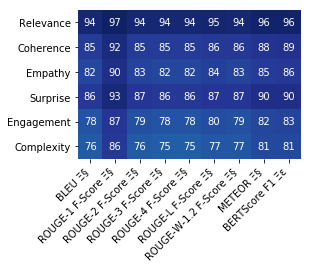

['ROUGE-1 F-Score Ξ§', 'BERTScore F1 Ξε', 'METEOR Ξ§']

In [266]:
my_func_sys_top(human_metrics, AEM_metrics, df_scores, d='pearson', x = 3, e = (4, 4))

#### Evaluation : Spearman correlation

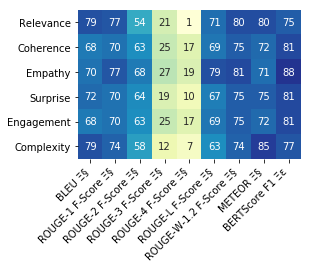

['BERTScore F1 Ξε', 'ROUGE-W-1.2 F-Score Ξ§', 'METEOR Ξ§']

In [267]:
my_func_sys_top(human_metrics, AEM_metrics, df_scores, d='spearman', x = 3, e = (4, 4))

#### Evaluation : Kendall correlation

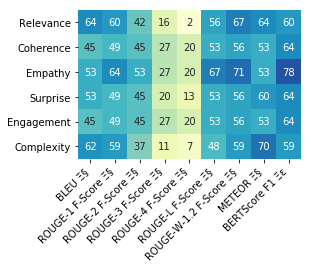

['BERTScore F1 Ξε', 'ROUGE-W-1.2 F-Score Ξ§', 'METEOR Ξ§']

In [268]:
my_func_sys_top(human_metrics, AEM_metrics, df_scores, d='kendall', x = 3, e = (4, 4))

In [302]:
import pandas as pd
import numpy as np
import json
from scipy.stats import pearsonr, kendalltau, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric_correlation(data_scores, global_metrics, human_scores, correlation_type='kendall'):

    corr_func = None
    if correlation_type == 'pearson':
        corr_func = pearsonr
    elif correlation_type == 'kendall':
        corr_func = kendalltau
    elif correlation_type == 'spearman':
        corr_func = spearmanr
    else:
        raise ValueError('Invalid correlation type. Valid options are: pearson, kendall, spearman')

    corr_values = []

    for metric in global_metrics:
        c_metric = np.array([json.loads(l) for l in data_scores[metric].tolist()]).T
        corr_metric = []
        for human_score in human_scores:
            c_human_score = np.array([json.loads(l) for l in data_scores[human_score].tolist()]).T
            corr, _ = corr_func(np.mean(c_metric, axis=0), np.mean(c_human_score, axis=0))
            corr_metric.append(abs(round(100*corr)))
        corr_values.append(corr_metric)

    # Create a dictionary to hold the correlation data
    corr_data = {
        'Metric': global_metrics,
        'Relevance': [corr[0] for corr in corr_values],
        'Coherence': [corr[1] for corr in corr_values],
        'Empathy': [corr[2] for corr in corr_values],
        'Surprise': [corr[3] for corr in corr_values],
        'Engagement': [corr[4] for corr in corr_values],
        'Complexity': [corr[5] for corr in corr_values]
    }

    df = pd.DataFrame.from_dict(corr_data)
    melted_df = df.melt(id_vars=['Metric'], var_name='Human Score', value_name='Correlation')

    sns.set(style='whitegrid')
    sns.set(rc={'figure.figsize':(10,6)})

    custom_palette = sns.color_palette("colorblind", n_colors=6)
    sns.set_palette(custom_palette)
    sns.lineplot(x='Human Score', y='Correlation', hue='Metric', marker='o', data=melted_df)

    plt.ylabel('Correlation with AEM (%)')
    plt.title(f'Correlation AEM metrics and Human scores ({correlation_type} correlation)')
    plt.xticks(rotation=28, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()


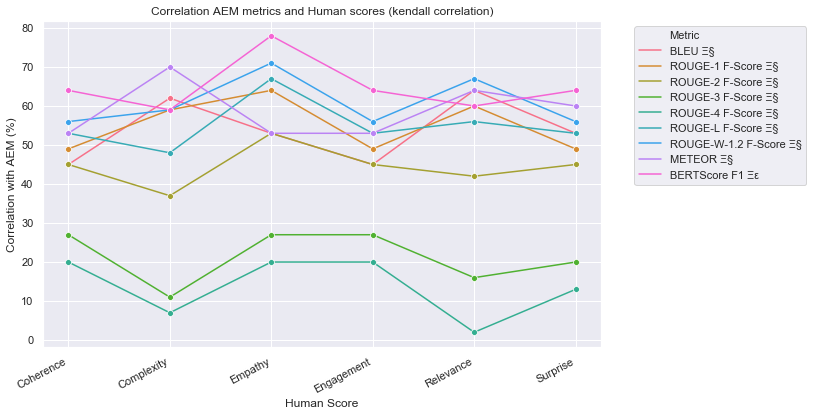

In [303]:
plot_metric_correlation(df_scores, AEM_metrics, human_metrics, correlation_type='kendall')


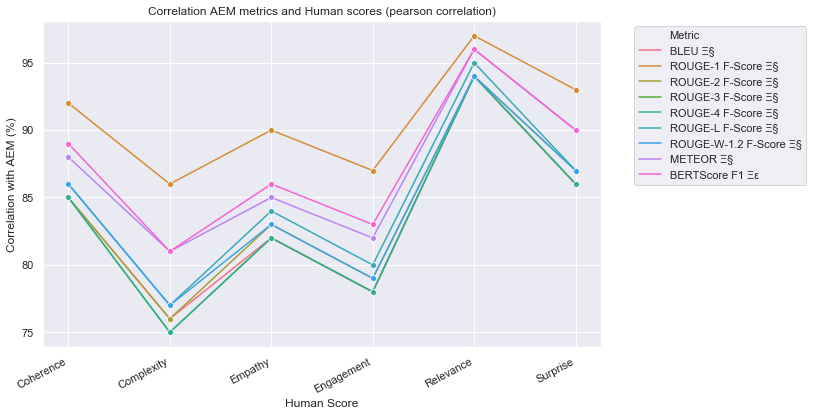

In [300]:
plot_metric_correlation(df_scores, AEM_metrics, human_metrics, correlation_type='pearson')


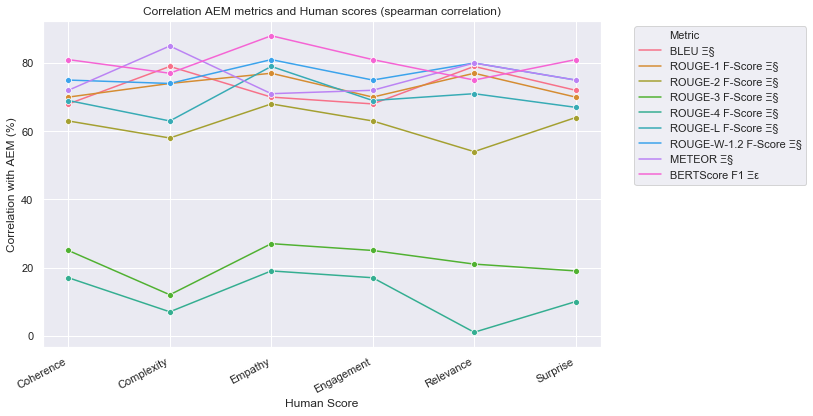

In [301]:
plot_metric_correlation(df_scores, AEM_metrics, human_metrics, correlation_type='spearman')



## <font color='orange'>Ranking the metrics using Borda’s count</font>

In [342]:
def my_func_sys_borda(a, b, c, d_list, x, e, f=None, g=None):
    N = len(a)
    M = len(b)
    corr_matrices = {}
    for d in d_list:
        corr_matrix = np.zeros((N, M))
        for i in range(N):
            for j in range(M):
                c_metric1 = np.array([json.loads(l) for l in c[a[i]].tolist()]).T
                c_metric2 = np.array([json.loads(l) for l in c[b[j]].tolist()]).T

                if d == 'kendall':
                    k = kendalltau(np.mean(c_metric1, axis=0), np.mean(c_metric2, axis=0))[0]
                    corr_matrix[i, j] = abs(round(100 * k))
                elif d == 'pearson':
                    k = pearsonr(np.mean(c_metric1, axis=0), np.mean(c_metric2, axis=0))[0]
                    corr_matrix[i, j] = abs(round(100 * k))
                elif d == 'spearman':
                    k = spearmanr(np.mean(c_metric1, axis=0), np.mean(c_metric2, axis=0))[0]
                    corr_matrix[i, j] = abs(round(100 * k))
        
        corr_matrices[d] = corr_matrix
    
    if g is None:
        nm2 = b
    else:
        nm2 = g
    if f is None:
        nm1 = a
    else:
        nm1 = f
        
    if a==b :
        uh = np.triu(np.ones_like(corr_matrices['pearson'], dtype=bool))
    else :
        uh = False 
        
    top_aem_list = {}
    for d in d_list:
        corr_matrix = corr_matrices[d]
        nm2 = np.array(nm2)
        #plt.figure(figsize=e)
        #heatmap = sns.heatmap(corr_matrix,annot=True,cmap='YlGnBu',square=True,vmin=0,vmax=100,xticklabels=nm2,yticklabels=nm1,cbar=False,mask=uh)
        #heatmap.set_xticklabels(heatmap.get_xticklabels(),rotation=45,ha='right')

        sorted_idx = np.argsort(corr_matrix.sum(axis=0))[::-1]
        sorted_idx_list = sorted_idx.tolist()
        top_aem = nm2[sorted_idx_list][:x]

        #plt.show()
        
        top_aem_list[d] = list(top_aem)

    return top_aem_list


In [343]:
my_func_sys_borda(human_metrics, AEM_metrics, df_scores, corr_interest, x=10, e = (4, 4), f=None, g=None)


{'pearson': ['ROUGE-1 F-Score Ξ§',
  'BERTScore F1 Ξε',
  'METEOR Ξ§',
  'ROUGE-L F-Score Ξ§',
  'ROUGE-W-1.2 F-Score Ξ§',
  'ROUGE-2 F-Score Ξ§',
  'BLEU Ξ§',
  'ROUGE-4 F-Score Ξ§',
  'ROUGE-3 F-Score Ξ§'],
 'kendall': ['BERTScore F1 Ξε',
  'ROUGE-W-1.2 F-Score Ξ§',
  'METEOR Ξ§',
  'ROUGE-L F-Score Ξ§',
  'ROUGE-1 F-Score Ξ§',
  'BLEU Ξ§',
  'ROUGE-2 F-Score Ξ§',
  'ROUGE-3 F-Score Ξ§',
  'ROUGE-4 F-Score Ξ§'],
 'spearman': ['BERTScore F1 Ξε',
  'ROUGE-W-1.2 F-Score Ξ§',
  'METEOR Ξ§',
  'ROUGE-1 F-Score Ξ§',
  'BLEU Ξ§',
  'ROUGE-L F-Score Ξ§',
  'ROUGE-2 F-Score Ξ§',
  'ROUGE-3 F-Score Ξ§',
  'ROUGE-4 F-Score Ξ§']}

In [335]:
lignes = ['ROUGE-1',
          'BERTScore',
          'METEOR',
          'ROUGE-L',
          'ROUGE-W-1.2',
          'ROUGE-2',
          'BLEU',
          'ROUGE-4',
          'ROUGE-3']
colonnes = ['Pearson', 'Kendall', 'Spearman']
borda_count = pd.DataFrame(index=lignes, columns=colonnes)
borda_count['Pearson']  = [1, 2, 3, 4, 5, 6, 7, 8, 9]
borda_count['Kendall']  = [5, 1, 3, 4, 2, 7, 6, 9, 8]
borda_count['Spearman'] = [4, 1, 3, 6, 2, 7, 5, 9, 8]
borda_count

,Pearson,Kendall,Spearman
ROUGE-1,1,5,4
BERTScore,2,1,1
METEOR,3,3,3
ROUGE-L,4,4,6
ROUGE-W-1.2,5,2,2
ROUGE-2,6,7,7
BLEU,7,6,5
ROUGE-4,8,9,9
ROUGE-3,9,8,8
